# 05 훈련 노하우를 배웁니다.

## 05-1 검증 세트를 나누고 전처리 과정을 배웁니다.

</br>
* loss 함수를 로지스틱 회귀로 모델 훈련하였었는데 서포트 벡터 머신(Support Vector Machine;SVM)으로 바꾸면 성능이 향상 될까요?


In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)

In [0]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test,y_test)

0.8333333333333334

In [0]:
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test,y_test)

0.9385964912280702

SVM으로 바꾸니 정확도가 10% 향상된 것을 볼 수 있습니다. 이 처럼 클래스의 매개변수를 바꾸는 것을 모델을 튜닝한다 라고 합니다.

### 테스트 세트로 모델을 튜닝하면 실전에서 좋은 성능을 기대하기 힘듭니다.

마치 시험문제를 달달 외운것과 같기 때문에 새로운 문제를 만나게 되면 좋은 성적을 기대하기 힘들다. 이처럼 테스트로 모델을 튜닝하면 실전에서 좋은 성능을 기대하기 힘든 것을 '테스트 세트의 정보가 모델에 새어 나갔다'라고 말합니다. 정리하면 테스트 세트로 모델을 튜닝하면 테스트 세트의 정보가 모델에 새어 나가므로 모델의 일반화 성능(generalization performance)이 왜곡됩니다.

### 검증 세트를 준비합니다.

따라서 모델을 튜닝하는데 사용할 데이터를 따로 준비해야 합니다. 이를 검증세트(validation set)라고 하며 훈련세트를 조금 뗴어 만듭니다.

훈련 : 검증 : 테스트 = 6 : 2: 2 비율로 할당합니다.



In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train),len(x_val))

364 91


In [0]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

검증 데이터 셋을 추가하면서 훈련 데이터 셋의 크기가 줄어들어 정확도가 줄어든 것을 확인할 수 있다. 일반적으로 10만 개 정도의 데이터가 있다며 8:1:1 정도로 나누고 100만 개 이상의 데이터는 98:1:1 정도의 비율로 나누게 됩니다.

### 데이터 전처리와 특성의 스케일을 알아봅니다.

지금까지는 사이킷런과 같은 머신러닝 패키지에 있는 데이터를 사용하였기 때문에 데이터 전처리(data preprocessing)이 필요없었지만 실제로 데이터를 수집하면 누락된 값이 있거나 데이터 형태가 균일하지 않을 수 있기 때문에 데이터 전처리 작업이 필요합니다.

먼저 데이터의 스케일(범위) 가 학습에 영향을 미칩니다. 따라서 모든 특성의 스케일을 맞추는 것을 스케일 조정이라고 합니다.

### 먼저 스케일을 조절하지 않고 모델을 훈련해보겠습니다.



['mean perimeter' 'mean area']


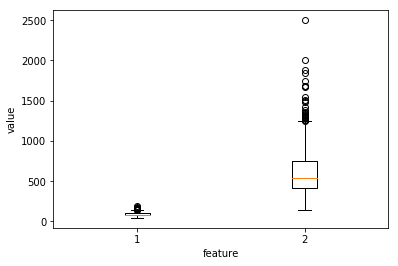

In [4]:
import matplotlib.pyplot as plt
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

두 특성의 스케일 차이가 큽니다.

learning_rate 는 하이퍼파라미터이며 변수 이름 그대로 학습률을 의미하는데 이 값으로 가중치의 업데이트 양을 조절할 것입니다.
만약 가중치를 큰 폭으로 업데이트하여 손실 함수가 최소가 될 수 있는 지점인 전역 최솟값을 지나쳐 버리게 되면 최적의 해를 구할 수 없습니다.

In [0]:
import numpy as np
class SingleLayer:
  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = []
    self.lr = learning_rate

  def forpass(self, x):
    return np.sum(x*self.w) + self.b
  
  def backprop(self, x, err):
    return x*err, err

  def add_bias(self, x):
    return np.c_[np.ones((x.shape[0],1)), x]
  def activation(self, z):
    return (1 / (1 + np.exp(-z)))

  def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))
      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.backprop(x[i], err)
        self.w -= self.lr*w_grad
        self.b -= b_grad
        self.w_history.append(self.w.copy())
        a = np.clip(a, 1e-10,1-1e-10) #안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다.

        loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
      self.losses.append(loss/len(y))

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0
  
  def score(self, x, y):
    return np.mean(self.predict(x) == y)

      
  

In [0]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


0.9120879120879121

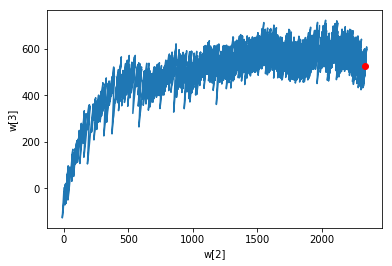

In [0]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

위와 같은 상황을 w3에 대한 그래디언트가 w2보다 크기 때문에 w3 축을 따라 가중치가 크게 요동치고 있다라고 표현합니다.
따라서 특성들의 스케일을 조정할 필요가 있음을 알 수 있습니다.

### 스케일을 조정해 모델을 훈련합니다.

$$z= \frac{x-\mu}{s}$$

위 공식은 표준화(standardization)을 위한 공식입니다. 특성값에서 평균을 배고 표준 편차로 나눈다는 뜻입니다.
표준화를 하면 평균이 0이고 분산이 1인 특성이 만들어진다고 합니다.
사이킷런에는 표준화를 위한 StandardScaler 클래스가 있지만 직접 만들어 보도록 합시다.


In [0]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean)/train_std

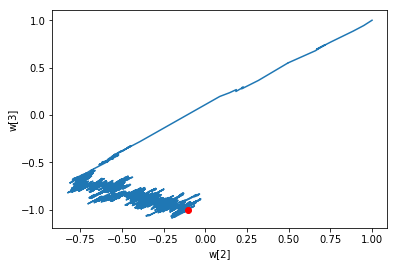

In [8]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

w2와 w3의 변화 비율이 비슷하기 때문에 대각선 방향으로 가중치가 이동되었습니다. 또한 두 특성의 스케일을 비슷하게 맞추었으므로 최적값에 빠르게 근접하고 있음을 알 수 있습니다. 이처럼 경사하강법에서는 서론 다른 특성의 스케일을 맞추는 것이 아주 중요합니다.

In [0]:
layer2.score(x_val, y_val)

0.37362637362637363

In [9]:
val_mean = np.mean(x_train, axis=0)
val_std = np.std(x_train, axis=0)
x_val_scaled = (x_val - val_mean)/val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

단 여기서 피해야할 함정이 있습니다. 검증세트를 표준화할 때 검증세트의 평균과 표준편차를 사용하였는데 이럴 경우 훈련세트와의 다른 비율로 변환될 수 있습니다.
따라서 검증세트를 표준화 할때 훈련세트의 평균과 표준편차를 사용하여야 합니다.

## 05-2 과대적합과 과소적합을 알아봅시다.

> <b>과대적합 (overfitting)</b>
<br>훈련세트에서는 좋은 성능을 내지만 검증 세트에서는 낮은 성능을 내는 경우를 말합니다. 훈련세트와 검증 세트에서 측정한 성능의 간격이 큽니다. 따라서 과대적합된 모델을 <b>'분산이 크다(high variance)'</b>라고도 말합니다. </br>
과대적합의 주요 원인은 훈련 세트에 충분히 다양한 패턴의 샘플이 포함되지 못한 경우입니다. 이럴때는 더 많은 훈련샘플을 모아 해결할 수 있는데 더 모으지 못하는 경우에는 모델이 훈련 세트에 집착하지 않도록 가중치를 제한할 수 있습니다. 이를 <b>'모델의 복잡도를 낮춘다'</b> 라고 합니다.


> <b>과소적합 (underfitting)</b></br>
훈련세트와 검증세트에서 측정한 성능의 간격은 점점 가까워지지만 성능 자체가 낮습니다. 과소 적합 모델은 <b>'편향이 크다(high bias)'</b>라고도 합니다. 과소적합을 해결하는 대표적인 방법은 복잡도가 더 높은 모델을 사용하거나 가중치의 규제를 완화하는 것입니다.

### 에포크와 손실 함수의 그래프로 과대적합과 과소적합 분석하기

에포크에 대한 손실 함수의 그래프를 학습 곡선이라고 부르는 경우도 있습니다. 과대적합의 경우 훈련 세트의 경우에는 손실이 계속 적어지지만 검증 세트의 손실은 오히려 최적점을 지나면 다시 증가 합니다. 과소적합의 경우 최적점에 도달하기 전에 학습을 중단하는 경우 과소 적합 모델이 됩니다. 에포크에 대한 정확도는 손실 함수의 반대입니다

### 모델 복잡도와 손실 함수의 그래프로 과대적합과 과소적합 분석하기

가끔은 가로 축에 에포크 대신 모델 복잡도를 넣어 그래프를 표현하기도 하는데, 모델이 무조건 복잡할 수록 좋은 것이 아니라 너무 복잡하면 훈련세트에만 잘 맞는 형태가 되면서 과대적합이 되기도 합니다

## 적절한 편향-분산 트레이드오프를 선택합니다.

앞에서 과소적합된 모델은 '편향되었다'라고 하고 과대적합된 모델은 '분산이 크다'라고 합니다. 트레이드오프라는 말이 들어간 이유는 하나를 얻기 위해서는 다른 하나를 희생해야 하기 때문입니다. 편향을 줄이면 분산이 커지고 분산을 줄이면 편향이 커지는 것을 말합니다. 따라서 분산이나 편향이 너무 커지지 않도록 적절한 중간 지점을 선택해야 합니다.

In [0]:
import numpy as np
class SingleLayer:
  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate

  def forpass(self, x):
    return np.sum(x*self.w) + self.b
  
  def backprop(self, x, err):
    return x*err, err

  def add_bias(self, x):
    return np.c_[np.ones((x.shape[0],1)), x]
  def activation(self, z):
    return (1 / (1 + np.exp(-z)))

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))
      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.backprop(x[i], err)
        self.w -= self.lr*w_grad
        self.b -= b_grad
        self.w_history.append(self.w.copy())
        a = np.clip(a, 1e-10,1-1e-10) #안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다.

        loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
      self.losses.append(loss/len(y))
      self.update_val_loss(x_val, y_val)
  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val))


  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0
  
  def score(self, x, y):
    return np.mean(self.predict(x) == y)

      
  

In [0]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train,100, x_val_scaled, y_val=y_val)

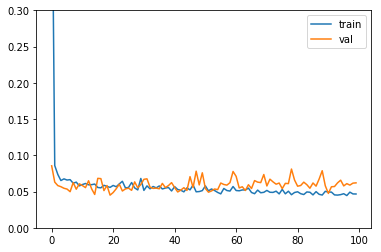

In [12]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.legend(['train', 'val'])
plt.show()

In [15]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20) # 그래프를 보면 20에서 validation loss 값이 train보다 더 높아지는 것을 볼 수 있습니다. (한 25까지 해볼만 한듯?)
layer4.score(x_val_scaled, y_val)

0.978021978021978

In [0]:
#과대 적합 되기 전에 훈련을 멈추었으므로 성능이 조금 더 향상 되었습니다

In [16]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=25) # 그래프를 보면 20에서 validation loss 값이 train보다 더 높아지는 것을 볼 수 있습니다. (한 25까지 해볼만 한듯?)
layer4.score(x_val_scaled, y_val)

0.978021978021978

## 05-3 규제 방법을 배우고 단일층 신경망에 적용합니다


## L1 규제

L1 규제라는 것은 손실함수에 가중치의 절대값이 L1 노름(norm)을 추가합니다. L1 노름은 다음과 같이 정의됩니다.

$$||w||_1 = \sum_{i=1}^{n}{|w_i|}$$

손실함수에 더할 때는 규제의 양을 조절하는 파라미터 $\alpha$를 곱한 후 더합니다.

$$L = -(y\log(a)+(1-y)\log(1-a)) + \alpha\sum_{i=1}^{n}{|w_i|}$$
이 손실함수를 w에 대해 미분하면 다음과 같이 됩니다.
$$\cfrac{\partial}{\partial w}L = -(y-a)x + a\times sign(w)$$
$$w = w - \eta \cfrac{\partial L}{\partial w} = w + \eta((y-a)x - a \times sign(w))$$

코드로 작성하면 다음과 같습니다

In [0]:
#w_grad += alpha * np.sign(w)

살펴보야 할 점은 절편에 대해 규제를 하지 않는다는 점입니다. 절편은 모델에 영향을 미치는 방식이 가중치와 다르기 떄문입니다. 절편을 규제하면 모델을 어떤 방향으로 이동시킬 뿐 복잡도에는 영향을 주지 않습니다. SGDClassifier 클래스에서 penalty 매개변수 값을 l1으로 지정하는 방법으로 L1 규제를 적용할 수 있습니다. 또 규제의 강도를 제어하는 하이퍼파라미터 $\alpha$를 위한 alpha 매개변수를 제공합니다.

### 회귀 모델에 L1규제를 추가한 것을 라쏘 모델이라 합니다.
라쏘는 가중치를 줄이다 못해 일부 가중치를 0으로 만들 수도 있습니다. 가중치가 0인 특성은 모델에서 사용할 수 없다는 것과 같은 의미이므로 특성을 선택하는 효과를 얻을 수 있습니다.

## L2 규제를 알아 봅시다.

L2규제는 손실 함수에 가중치에 대한 L2 노름(norm)의 제곱을 더합니다. 

$$||w||_2 = \sqrt{\sum_{i=1}^n{|w_i|^2}}$$

L1규제와 동일하게 미분하면 w에 alpha 값을 곱해서 더하면 됩니다.

w_grad += alpha * w

L2 규제는 그레디언트 계싼에 가중치의 값 자체가 포함되므로 가중치의 부호만 사용하는 L1규제보다 조금 더 효과적입니다. 또 L2 규제는 가중치를 완전히 0으로 만들지 않습니다. 가중치를 0으로 만들면 특성을 제외하는 효과는 있지만 모델의 복잡도가 떨어집니다. 이런 이유로 L2 규제를 널리 사용합니다.

### 회귀 모델에 L2 규제를 적용한 것을 릿지 모델이라 합니다.

In [0]:
# L1 규제와 L2 규제를 적용합니다.

import numpy as np
class SingleLayer:
  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
    

  def forpass(self, x):
    return np.sum(x*self.w) + self.b
  
  def backprop(self, x, err):
    return x*err, err

  def add_bias(self, x):
    return np.c_[np.ones((x.shape[0],1)), x]
  def activation(self, z):
    return (1 / (1 + np.exp(-z)))

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))
      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.backprop(x[i], err)
        #L1 , L2 규제 적용
        w_grad += self.l1 * np.sign(self.w) + self.l2*self.w
        self.w -= self.lr*w_grad
        self.b -= b_grad
        self.w_history.append(self.w.copy())
        a = np.clip(a, 1e-10,1-1e-10) #안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다.

        loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
       # 에포크마다 평균 손실을 저장합니다
      self.losses.append(loss/len(y))
      self.update_val_loss(x_val, y_val)
  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val) + self.reg_loss())
  
  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0
  
  def score(self, x, y):
    return np.mean(self.predict(x) == y)

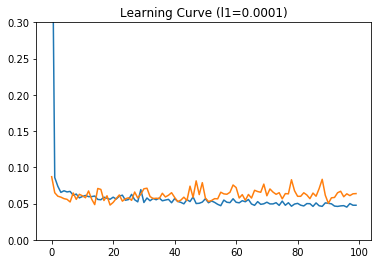

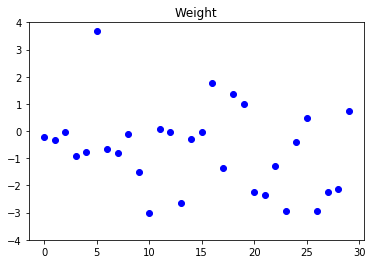

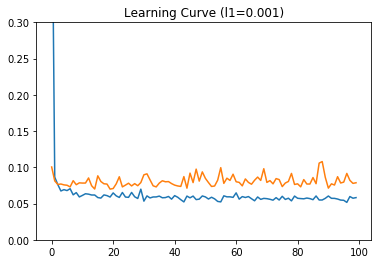

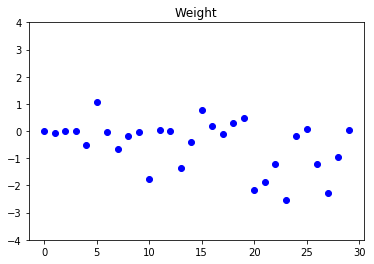

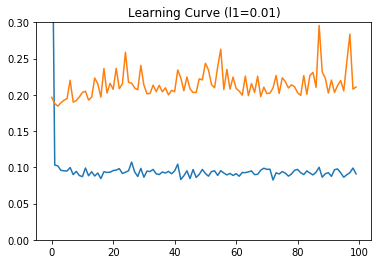

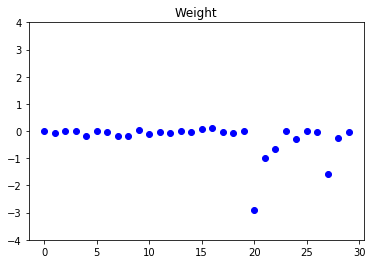

In [12]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
  lyr = SingleLayer(l1=l1)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
  
  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l1={})'.format(l1))
  plt.ylim(0, 0.3)
  plt.show()
  
  plt.plot(lyr.w, 'bo')
  plt.title('Weight')
  plt.ylim(-4, 4)
  plt.show()

학습 곡선 그래프를 보면 규제가 커질수록 훈련 세트의 손실과 검증 세트의 손실이 모두 높아집니다.
또한 l1 값이 커질 수록 가중치의 값이 0에 가까워지는 것을 볼 수 있습니다.

다만 데이터 세트가 작아서 규제 효과가 크게 나타나지는 않습니다.

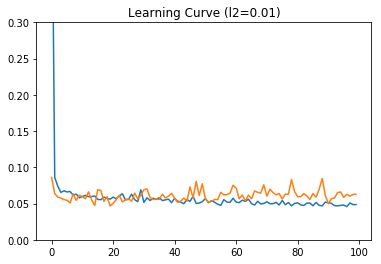

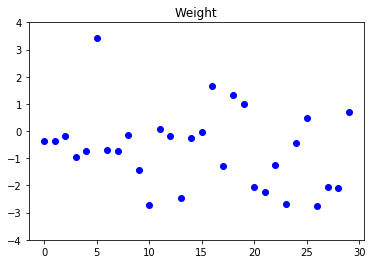

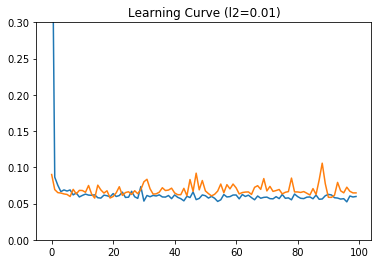

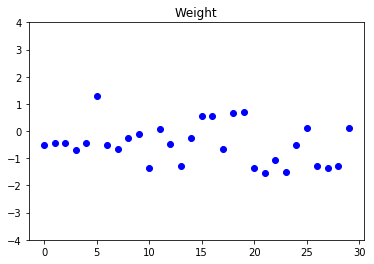

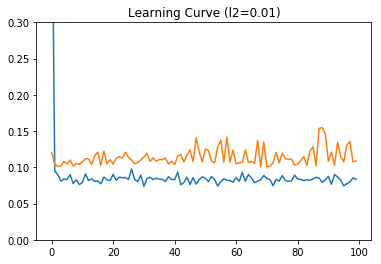

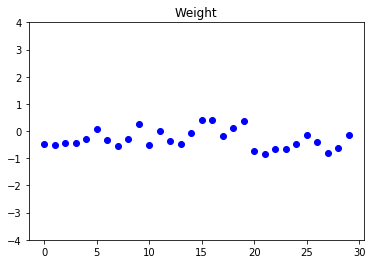

In [13]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2=l2)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
  
  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l2={})'.format(l1))
  plt.ylim(0, 0.3)
  plt.show()
  
  plt.plot(lyr.w, 'bo')
  plt.title('Weight')
  plt.ylim(-4, 4)
  plt.show()

두 그래프를 보면 L2 규제도 L1 규제와 비슷한 양상을 보이지만 L1 규제만큼 과소적합이 심해지지 않고 가중치 역시 0에 너무 가깝게 줄어들지 않는다는 것도 알 수 있습니다. 

L2 규제 역시 마찬가지로 cancer 데이터 세트의 샘플 개수가 적어서 규제를 적용해도 모델의 성능에는 큰 차이가 없습니다

다만 L1 규제가 L2 규제보다 가중치를 강하게 제한하지 않아서 손실값이 일정한 수준으로 유지되지 않아서 전역 최소값을 찾는 과정을 오래 반복할 수 없습니다

### SGDClassifier에서 규제 사용하기

In [15]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

## 05-4 교차 검증을 알아보고 사이킷런으로 수행해 봅니다

교차 검증(cross validation)은 이런 경우에 사용하면 좋습니다. 훈련 세트의 샘플 개수가 줄어들어 모델을 훈련시킬 데이터가 부족해지는 경우입니다.

### 교차 검증의 원리를 알아봅니다.

교차 검증은 훈련 세트를 작은 덩어리로 나누어 다음과 같이 진행하는데, 이때 훈련 세트를 나눈 작은 덩어리를 '폴드'라고 부릅니다.
훈련 세트를 k개의 폴드로 나누는 특징이 있으므로 k-폴드 교차 검증이라고 부릅니다. 검증 세트도 테스트에 사용할 수 있기 때문에 더 많은 데이터로 훈련할 수 있습니다.

In [16]:
validation_scores = []

k = 10
bins = len(x_train) // k

for i in range(k):
  start = i*bins
  end = (i+1)*bins
  
  val_fold = x_train_all[start:end]
  val_target = y_train_all[start:end]
  
  train_index = list(range(0, start)) + list(range(end, len(x_train)))
  train_fold = x_train_all[train_index]
  train_target = y_train_all[train_index]
  
  train_mean = np.mean(train_fold, axis=0)
  train_std = np.std(train_fold, axis=0)
  train_fold_scaled = (train_fold - train_mean) / train_std
  val_fold_scaled = (val_fold - train_mean) / train_std
  
  lyr = SingleLayer(l2=0.01)
  lyr.fit(train_fold_scaled, train_target, epochs=50)
  score = lyr.score(val_fold_scaled, val_target)
  validation_scores.append(score)
  
print(np.mean(validation_scores))

0.9583333333333333


In [17]:
validation_scores

[0.9444444444444444,
 0.9722222222222222,
 0.9722222222222222,
 0.9722222222222222,
 0.9166666666666666,
 0.8333333333333334,
 1.0,
 1.0,
 1.0,
 0.9722222222222222]

### 사이킷런으로 교차 검증을 합니다

사이킷런의 model_selection 모듈에는 교차 검증을 위한 corss_validate() 함수가 있습니다. SingleLayer 클래스와 cross_validate()함수를 같이 사용하려면 SingleLayer 클래스에 몇 가지 기능을 추가해야 합니다. 다만 이 기능을 구현하는 것은 이 책의 범위를 벗어나므로 구현하지 않고 SGDClassifier 클래스와 cross_validate() 함수를 어떻게 사용하는지에 대해서만 알아보겠습니다.



In [18]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)

print(np.mean(scores['test_score']))

0.850096618357488


결과 값이 낮은 이유는 전처리 단계를 안 해서 그렇습니다. 앞에서는 교차 검증을 구현할 때 폴드를 나눈 후에 훈련 폴드의 통계치로 검증폴드를 전처리 했습니다. 검증폴드가 전처리 단계에서 누설되면 안 되기 때문이죠. 만약 훈련 세트 전체를 전처리한 후에 cross_validate()함수에 매개변수 값으로 전달하면 검증 폴드가 표준화 전처리 단계에서 누설됩니다. 그래서 새로운 방법을 찾아야 합니다.

### Pipeline 클래스 사용해 교차 검증 수행하기

이 해결책은 Pipeline 클래스로 해결할 수 있습니다. Pipeline 클래스로 SGDClassifier 클래스를 감싸서 cross_validate()함수에 전달하면 cross_validate()함수는 훈련 세트를 훈련 폴드와 검증 폴드로 나누기만 하고 전처리 단계와 SGDClassifier 클래스 객체의 호출은 Pipeline 클래스 객체에서 이뤄집니다. 이렇게 하면 검증 폴드가 전처리 단계에서 누설되지 않게 됩니다.



In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv = 10, return_train_score = True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [21]:
print(np.mean(scores['train_score']))

0.9875478561631581


지금까지 단일층 신경망을 만들어봤고 유용한 훈련 방법도 배웠습니다. 다음 장에서는 여러개의 층이 있는 신경만 구조인 '다층 신경망 알고리즘'을 구현해 보겠습니다.